# Headline generation from one-sentence article summaries

### Gabriel Strauss

For this assignment, I built a sequence-to-sequence text summarization model and trained it to produce news article headlines from one-sentence article summaries. I added attention to the model using a provided Attention layer.

### Contents:
1. Input loading and pre-processing
2. Implementation of Unidirectional LSTM encoder-decoder
3. Implementation of Unidirectional LSTM encoder-decoder with Attention layer
4. Analysis
5. Proposed and implemented model improvements

# Preparing Inputs

In [12]:
from collections import Counter
print("importing numpy")
import numpy as np
from os import listdir
import random
print("importing keras")
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, h5py, save_model, load_model
from keras.layers import Embedding, Dense, Dropout, TimeDistributed, Activation, LSTM, RepeatVector
#from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint, TensorBoard
#from keras import initializers
from keras import backend as K
from keras.optimizers import SGD
from keras.optimizers import Adadelta
from keras.preprocessing import sequence
from keras import optimizers

from rouge import Rouge

import attention_decoder

import pickle

print("done")

importing numpy
importing keras
done


### data loading helper functions

In [13]:
#takes a .txt file name, returns list of lines.
def file_to_lines(text_file):
    lines = []
    line = "/"
    with open(text_file, 'r', encoding='utf-8') as f:
        i = 0
        while line != "":
            line = f.readline()
            if line != "":
                #line = ' '.join(['<s>',line])
                lines.append(line)
    
    return lines

#takes a valid filepath
#returns list of sentences tokenized with whitespace delimiter
def lines_to_tokens(lines):
    tokens = []
    for line in lines:
        tokens.extend(line.split())
    
    return tokens    

#takes a list of tokenized sentences and max # of types, returns list of types (vocab)
def create_idx2word(vocab_size, tokens):
           
    vocab = list(list(zip(*Counter(tokens).most_common(vocab_size + 1)))[0])
    if '<unk>' in vocab:
        vocab.remove('<unk>')
    vocab.insert(0, 'ZERO')
    vocab.append('UNK')
    
    return vocab

#generate {token : idx} dict
def create_word2idx(idx2word):
    return {idx2word[i] : i for i in range(0, len(idx2word))}

#replace words not in vocab with "UNK," pad all idx sequences to max_len
def transform_data(word2idx, lines, max_len):
    
    transformed_data = []
    for line in lines:
        line2idx = []
        for tok in line.split():
            #if word not in vocab append 'UNK' idx to idx sequence
            try:
                idx = word2idx[tok]
                line2idx.append(idx)
            except KeyError:
                line2idx.append(VOCAB_SIZE + 1)
        transformed_data.append(line2idx)
        
    transformed_data = pad_sequences(transformed_data, value=0, maxlen=max_len)
    
    return transformed_data

#decodes idx sequence to string
def decode_sequence(idx2word, sequence):
    return " ".join([idx2word[i] for i in sequence])

### Function for loading and processing train data

In [14]:
def load_train_data(article, summary, max_len, vocab_size):
    
    #read in files, return array of lines as strings
    article_lines = file_to_lines(article)
    title_lines = file_to_lines(summary)

    #article_lines = article_lines[:65]
    #title_lines = title_lines[:65]
    #tokenize each line, return single array of all tokens
    article_toks = lines_to_tokens(article_lines)
    title_toks = lines_to_tokens(title_lines)
    
    article_idx2word = create_idx2word(vocab_size, article_toks)
    title_idx2word = create_idx2word(vocab_size, title_toks)

    article_word2idx = create_word2idx(article_idx2word)
    title_word2idx = create_word2idx(title_idx2word)
    
    article_data = transform_data(article_word2idx, article_lines, MAX_LEN)
    title_data = transform_data(title_word2idx, title_lines, MAX_LEN)

    return (article_data, len(article_idx2word), article_idx2word, article_word2idx,\
            title_data, len(title_idx2word), title_idx2word, title_word2idx)


### Functions for loading and processing test data

In [15]:
def load_test_data_for_prediction(article_f, summary_f):
    
    print("Loading test data...")
    
    #read in files, return array of lines as strings
    article_lines = file_to_lines(article_f)
    title_lines = file_to_lines(summary_f)
    
    article_lines = article_lines
    title_lines = title_lines

    for i in range(len(article_lines)):
        article_lines[i] = article_lines[i].replace('<unk>', 'UNK')
        title_lines[i] = title_lines[i].replace('<unk>', 'UNK')
        
    
    article_data = transform_data(X_word2idx, article_lines, MAX_LEN)
    #strip newline char
    title_lines = [line.strip('\n') for line in title_lines]

    
    return article_data, title_lines

#given model and X_test, returns list of decoded predicted titles y_pred
def predict_on_model(model, X_test):
    
    print("Predicting on X_test...")
    y_prob = model.predict(X_test)
    print("Preparing data for Rouge scoring...")

    #process Y data for Rouge scoring by
    #1. removing all 'ZERO' tokens
    #2. replacing words not in train vocab with 'UNK'
    
    y_pred = []
    
    for sequence in y_prob:
        sentence = []
        for vec in sequence:
            word = y_idx2word[np.argmax(vec)]
            if word != 'ZERO':
                if word in y_idx2word:
                    sentence.append(word)
                else:
                    sentence.append(y_idx2word[-1]) #set to 'UNK'
        y_pred.append(' '.join(sentence))
    
    return y_pred

### Load train and test data

In [5]:
MAX_LEN = 20
VOCAB_SIZE = 20000

article = 'data/train_article.txt'
summary = 'data/train_title.txt'

article_test = 'data/test_article.txt'
title_test = 'data/test_title.txt'

data = load_train_data(article, summary, MAX_LEN, VOCAB_SIZE)

X_train = data[0]
y_train = data[4]
X_vocab_len, y_vocab_len = data[1], data[5]
X_idx2word, y_idx2word = data[2], data[6]
X_word2idx, y_word2idx = data[3], data[7]

X_test, y_true = load_test_data_for_prediction(article_test, title_test)

#DON'T OVERWRITE UNLESS RETRAINING MODEL
with open("m1_vocab.pkl", 'wb') as f:
    pickle.dump([X_idx2word, y_idx2word, X_word2idx, y_word2idx], f)

print("data loaded and saved")

Loading test data...
data loaded and saved


# Unidirectional LSTM Encoder Decoder 

### Parameters for the LSTM encoder-decoder model 

In [6]:
BATCH_SIZE = 500
HIDDEN_DIM = 512
EPOCHS = 150
DROPOUT = 0.2
RECURRENT_DROP=0.5

### Model architecture

In [7]:
#CITATION: architecture based on https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/
#added dropout, recurrent dropout, and modified as necessary to work with sparse_categorical_crossentropy loss func

def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, drop, recur_drop):
    
    model = Sequential()
    model.add(Embedding(X_vocab_len, hidden_size, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size, recurrent_dropout=recur_drop, dropout=drop))
    model.add(RepeatVector(y_max_len))
    model.add(LSTM(hidden_size, recurrent_dropout=recur_drop, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    
    model.summary()
    
    return model

### Build and train the Model

In [8]:
print("Build model...")

model = create_UniLSTM(X_vocab_len, MAX_LEN, 
                       y_vocab_len, MAX_LEN,
                       HIDDEN_DIM, DROPOUT, RECURRENT_DROP)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 512)           10241024  
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 20, 512)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 512)           2099200   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 20, 20002)         10261026  
_________________________________________________________________
activation_1 (Activation)    (None, 20, 20002)         0         
Total params: 24,700,450
Trainable params: 24,700,450
Non-trainable params: 0
_________________________________________________

In [9]:
print('Train...')

for i in range(EPOCHS):
    print("META-EPOCH {}/{}".format(i+1, EPOCHS))
    model.fit(X_train, np.expand_dims(y_train, axis=-1), 
               epochs=1, batch_size=BATCH_SIZE)
    
    #assess rouge scores every 10 epochs, save if new max
    if (i+1)%10 == 0:
        
        y_pred = predict_on_model(model, X_test[0:1000])
        scores = Rouge().get_scores(hyps=y_pred, refs=y_true[0:1000], avg=True)
        
        #meant to include line below before running (see note above cell)
        print("ROUGE-2: {}".format(scores['rouge-2']['f']))
        weight_f = "weights/m1/rouge{}-e{}.h5".format(int(scores['rouge-2']['f'] * 100), i)
        model.save_weights(weight_f)
        print("Saved weights to {}".format(weight_f))
                  
print("a fitting end")

Train...
META-EPOCH 1/150
Epoch 1/1
50000/50000 [==============================] - 146s - loss: 3.7226 - acc: 0.6229   
META-EPOCH 2/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 3.3181 - acc: 0.6292   
META-EPOCH 3/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 3.2014 - acc: 0.6293   
META-EPOCH 4/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 3.1271 - acc: 0.6313   
META-EPOCH 5/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 3.0392 - acc: 0.6335   
META-EPOCH 6/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 2.9825 - acc: 0.6357   
META-EPOCH 7/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 2.9455 - acc: 0.6368   
META-EPOCH 8/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 2.9099 - acc: 0.6383   
META-EPOCH 9/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 2.8718 - acc: 0.

50000/50000 [==============================] - 126s - loss: 1.2225 - acc: 0.7332   
META-EPOCH 68/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 1.2080 - acc: 0.7348   
META-EPOCH 69/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 1.1915 - acc: 0.7370   
META-EPOCH 70/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 1.1773 - acc: 0.7385   
Predicting on X_test...
Preparing data for Rouge scoring...
ROUGE-2: 0.014648702152854163
Saved weights to weights/m1/rouge1-e69.h5
META-EPOCH 71/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 1.1629 - acc: 0.7403   
META-EPOCH 72/150
Epoch 1/1
50000/50000 [==============================] - 127s - loss: 1.1470 - acc: 0.7422   
META-EPOCH 73/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 1.1336 - acc: 0.7443   
META-EPOCH 74/150
Epoch 1/1
50000/50000 [==============================] - 126s - loss: 1.1202 - acc: 0.7456   


# Evaluation using Rouge score 

## Best model  

The output above is from my best model. I trained for 200 epochs first, then for 150. I achieved higher results with my model that only trained for 150.

### Parameters

BATCH_SIZE = 500  
NUM_LAYERS = 1  
HIDDEN_DIM = 512  
EPOCHS = 150  
DROPOUT = 0.2 (ONLY IN INPUT LSTM)  
RECURRENT_DROPOUT = 0.5 (IN BOTH LSTMS)  
MAX_LEN = 20 (for both input and output)
VOCAB_SIZE = 20000 
LOSS FUNCTION: sparse_categorical_crossentropy

### Results

Also summarized more cleanly below, in the analysis section

Rouge 1: {'p': 0.22011826427540712, 'r': 0.15925309494467163, 'f': 0.17797990767379282}  
Rouge 2: {'p': 0.0617637136672851, 'r': 0.059078128419199842, 'f': 0.05951144373271984}  
Rouge l: {'p': 0.15801677905427908, 'r': 0.15411964105336168, 'f': 0.14826568669338705}  

###  run cell below to confirm results
(takes around 1-3 min to build model, load weights, run predict, calculate rouge)

In [10]:

print("Build model...")
model = create_UniLSTM(X_vocab_len, MAX_LEN, 
                    y_vocab_len, MAX_LEN,
                    HIDDEN_DIM, NUM_LAYERS, DROPOUT, RECURRENT_DROP)
model.load_weights("weights/m1/rouge2-e149.h5")


MAX_LEN = 20
VOCAB_SIZE = 20000

article_test = 'data/test_article.txt'
title_test = 'data/test_title.txt'

data = load_train_data(article, summary, MAX_LEN, VOCAB_SIZE)

X_train = data[0]
y_train = data[4]
X_vocab_len, y_vocab_len = data[1], data[5]
#ignore data[2], data[3], data[6], data[7]. Instead, load idx2word and word2idx with code block below

#FIX to Counter most_common indeterminacy problem:
#reload idx2word and word2idx generated at time of training
with open("m1_vocab.pkl", "rb") as f:
    X_idx2word, y_idx2word, X_word2idx, y_word2idx = pickle.load(f)

X_test, y_true = load_test_data_for_prediction(article_test, title_test)

print("data loaded")

y_pred = predict_on_model(model, X_test)
scores = Rouge().get_scores(hyps=y_pred, refs=y_true, avg=True)
print("Rouge 1: {}".format(scores['rouge-1']))
print("Rouge 2: {}".format(scores['rouge-2']))
print("Rouge l: {}".format(scores['rouge-l']))

Predicting on X_test...
Preparing data for Rouge scoring...
Rouge 1: {'r': 0.15788385525538889, 'f': 0.17884880141042794, 'p': 0.22624065141207997}
Rouge 2: {'r': 0.059027805527805524, 'f': 0.060137788702927825, 'p': 0.063325200989486699}
Rouge l: {'r': 0.15283525288903441, 'f': 0.14900280045450692, 'p': 0.16150733450722946}


# Tensorboard Visualization 

Run model with tensorboard output on less data for shorter number of epochs, to confirm learning

### Make a new copy of model before running for visualization

In [24]:
tboard_model = create_UniLSTM(X_vocab_len, MAX_LEN, 
                       y_vocab_len, MAX_LEN,
                       HIDDEN_DIM, NUM_LAYERS, DROPOUT, RECURRENT_DROP)

BATCH_SIZE = 100

def generate_batch(X, Y, batch_size):
    i = 0
    j = batch_size + 1
    while True:
        input_data = np.array(X[i:j])
        target_data = np.array(Y[i:j])
        target_data = np.expand_dims(target_data, axis=-1)        
        
        if j >= len(X):
            i = 0
            j = batch_size + 1
        else:
            i = j
            j += batch_size
        
        yield (input_data, target_data)

tboard = TensorBoard(log_dir='./logs')

tboard_model.fit_generator(generate_batch(X_data, y_data, BATCH_SIZE), 
                    steps_per_epoch=200, epochs=10,
                    verbose=1, callbacks=[tboard])


Epoch 1/10
200/200 [==============================] - 69s - loss: 3.6004 - acc: 0.6242    
Epoch 2/10
200/200 [==============================] - 69s - loss: 3.2433 - acc: 0.6341    
Epoch 3/10
200/200 [==============================] - 69s - loss: 3.2393 - acc: 0.6283    
Epoch 4/10
200/200 [==============================] - 69s - loss: 3.1414 - acc: 0.6328    
Epoch 5/10
200/200 [==============================] - 69s - loss: 2.9995 - acc: 0.6370    
Epoch 6/10
200/200 [==============================] - 68s - loss: 3.0279 - acc: 0.6334    
Epoch 7/10
200/200 [==============================] - 68s - loss: 2.9159 - acc: 0.6405    
Epoch 8/10
200/200 [==============================] - 68s - loss: 2.9555 - acc: 0.6349    
Epoch 9/10
200/200 [==============================] - 69s - loss: 2.9272 - acc: 0.6372    
Epoch 10/10
200/200 [==============================] - 69s - loss: 2.8395 - acc: 0.6405    


![tensorboard_graph](tensorboard.png)


# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

From assignment instructions: "We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before."

In [5]:
VOCAB_SIZE = 10000
MAX_LEN = 20

article = 'data/train_article.txt'
summary = 'data/train_title.txt'

article_test = 'data/test_article.txt'
title_test = 'data/test_title.txt'

data = load_train_data(article, summary, MAX_LEN, VOCAB_SIZE)

X_train = data[0]
y_train = data[4]
X_vocab_len, y_vocab_len = data[1], data[5]
X_idx2word, y_idx2word = data[2], data[6]
X_word2idx, y_word2idx = data[3], data[7]

X_test, y_true = load_test_data_for_prediction(article_test, title_test)

vocab = [X_idx2word, y_idx2word, X_word2idx, y_word2idx]

#DON'T OVERWRITE UNLESS RETRAINING MODEL
#with open("m2_vocab.pkl", 'wb') as f:
#    pickle.dump(vocab, f)

print("data loaded and saved")

Loading test data...
data loaded and saved


In [18]:
BATCH_SIZE = 200
HIDDEN_DIM = 128
EPOCHS = 50
DROPOUT = 0.2
RECURRENT_DROP=0.5

In [16]:
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, 
                                hidden_size, drop, recur_drop, return_probs = False):
         
    model = Sequential()
    model.add(Embedding(X_vocab_len, hidden_size, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size, recurrent_dropout=recur_drop, dropout=drop, return_sequences=True))
    model.add(attention_decoder.AttentionDecoder(hidden_size, y_vocab_len, return_probabilities=return_probs))
    model.compile(loss='sparse_categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    
    model.summary()
    
    return model

### Build and train the Model

Train the model, as you did before, for the model without attention

In [8]:
#may take 5-20 minutes
print("Build model...")

attn_model = create_UniLSTMwithAttention(X_vocab_len, MAX_LEN, 
                                           y_vocab_len, MAX_LEN,
                                           HIDDEN_DIM, DROPOUT, RECURRENT_DROP)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           1280256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 10002)         106599382 
Total params: 108,011,222
Trainable params: 108,011,222
Non-trainable params: 0
_________________________________________________________________


#### Output only shown for epochs 1-36 because I ran the model with computer in sleep, & server stopped sending messages to I/O
However I tested rouge scores with all saved weights, and the scores presented below are from the weights saved after the final (50th epoch)

In [9]:
print('Train...')

for i in range(EPOCHS):
    print("META-EPOCH {}/{}".format(i, EPOCHS))
    attn_model.fit(X_train, np.expand_dims(y_train, axis=-1), 
                    epochs=1, batch_size=BATCH_SIZE)

    #assess rouge scores every 5 epochs
    if (i+1)%5 == 0:
        
        y_pred = predict_on_model(attn_model, X_test[0:1000])
        scores = Rouge().get_scores(hyps=y_pred, refs=y_true[0:1000], avg=True)
        
        print("ROUGE-2: {}".format(scores['rouge-2']['f']))
        weight_f = "weights/m2/rouge{}-e{}.h5".format(int(scores['rouge-2']['f'] * 100), i)
        attn_model.save_weights(weight_f)
        print("Saved weights to {}".format(weight_f))
                  
print("a fitting end")

Train...
META-EPOCH 0/50
Epoch 1/1
50000/50000 [==============================] - 561s - loss: 4.0122 - acc: 0.5335   
META-EPOCH 1/50
Epoch 1/1
50000/50000 [==============================] - 538s - loss: 3.5784 - acc: 0.5486   
META-EPOCH 2/50
Epoch 1/1
50000/50000 [==============================] - 537s - loss: 3.4980 - acc: 0.5509   
META-EPOCH 3/50
Epoch 1/1
50000/50000 [==============================] - 537s - loss: 3.4251 - acc: 0.5539   
META-EPOCH 4/50
Epoch 1/1
50000/50000 [==============================] - 536s - loss: 3.3603 - acc: 0.5561   
Predicting on X_test...
Preparing data for Rouge scoring...
ROUGE-2: 0.0019214507386460578
Saved weights to weights/m2/rouge0-e4.h5
META-EPOCH 5/50
Epoch 1/1
50000/50000 [==============================] - 537s - loss: 3.2994 - acc: 0.5585   
META-EPOCH 6/50
Epoch 1/1
50000/50000 [==============================] - 536s - loss: 3.2474 - acc: 0.5608   
META-EPOCH 7/50
Epoch 1/1
50000/50000 [==============================] - 536s - loss: 3.2

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Evaluation using Rouge Score

## Best model summary

### Parameters

BATCH_SIZE = 200  
HIDDEN_DIM = 128  
EPOCHS = 50  
DROPOUT = 0.2 (ONLY IN INPUT LSTM)  
RECURRENT_DROPOUT = 0.5 (IN BOTH LSTMS)  
MAX_LEN = 20 (for both input and output)
VOCAB_SIZE = 10000 
LOSS FUNCTION: sparse_categorical_crossentropy

### Results

Summarized more cleanly in analysis section below)

Rouge 1: {'r': 0.17391243064005885, 'p': 0.35230606575963713, 'f': 0.21562212026991187}  
Rouge 2: {'r': 0.061693226871168037, 'p': 0.063858936301793442, 'f': 0.060642030930029928}  
Rouge l: {'r': 0.1689324853052816, 'p': 0.17733595253952394, 'f': 0.16163418511859839}  


### run cell below to load weights from trained model and confirm results
(takes around 10 min to build model, then around 3-5 min to predict on X_test and calculate rouge)

In [19]:

MAX_LEN = 20
VOCAB_SIZE = 10000

article_test = 'data/test_article.txt'
title_test = 'data/test_title.txt'

data = load_train_data(article_test, title_test, MAX_LEN, VOCAB_SIZE)

X_train = data[0]
y_train = data[4]
X_vocab_len, y_vocab_len = data[1], data[5]
#ignore data[2], data[3], data[6], data[7]. Instead, load idx2word and word2idx with code block below

#reload idx2word and word2idx generated at time of training
with open("m2_vocab.pkl", "rb") as f:
    X_idx2word, y_idx2word, X_word2idx, y_word2idx = pickle.load(f)

    

print("Build model...")
attn_model = create_UniLSTMwithAttention(X_vocab_len, MAX_LEN, 
                                           y_vocab_len, MAX_LEN,
                                           HIDDEN_DIM, DROPOUT, RECURRENT_DROP)
attn_model.load_weights("weights/m2/rouge1-e49.h5")



X_test, y_true = load_test_data_for_prediction(article_test, title_test)

print("data loaded")


article_test = 'data/test_article.txt'
summary_test = 'data/test_title.txt'
X_test, y_true = load_test_data_for_prediction(article_test, summary_test)
y_pred = predict_on_model(attn_model, X_test)
scores = Rouge().get_scores(hyps=y_pred, refs=y_true, avg=True)
print("Rouge 1: {}".format(scores['rouge-1']))
print("Rouge 2: {}".format(scores['rouge-2']))
print("Rouge l: {}".format(scores['rouge-l']))


Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 128)           1280256   
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 20, 10002)         106599382 
Total params: 108,011,222
Trainable params: 108,011,222
Non-trainable params: 0
_________________________________________________________________
Loading test data...
data loaded
Loading test data...
Predicting on X_test...
Preparing data for Rouge scoring...
Rouge 1: {'r': 0.17391243064005885, 'f': 0.21562212026991187, 'p': 0.35230606575963713}
Rouge 2: {'r': 0.061693226871168037, 'f': 0.060642030930029928, 'p': 0.063858936301793442}
Rouge l: {'r': 0.1689324853052816, 'f': 0.16163418511859839, 'p': 0.1773359525395239

#### Run cell below to save predictions

In [ ]:
with open("m2_y_pred.txt", 'w', encoding='utf-8') as f:
    [f.write(line + '\n') for line in y_pred]

# Analysis

## Input / Gold Output / Basic LSTM / Attention Model Results table


### BASIC LSTM ROUGE SCORES:
#### Rouge 1  
    r: 15.93  
    p: 22.01  
    f: 17.8  
#### Rouge 2:  
    r: 5.91  
    p: 6.18  
    f: 5.95
### LSTM WITH ATTENTION ROUGE SCORES:
#### Rouge 1  
    r: 17.39  
    p: 35.23  
    f: 23.56  
#### Rouge 2:  
    r: 6.17  
    p: 6.39  
    f: 6.06

## Prediction visualization

### 5 GOOD PREDICTIONS  

INPUT: germany 's stocks opened higher tuesday on the frankfurt stock exchange .
  
GOLD: german stocks open higher
  
BASIC LSTM: german stocks open higher
  
ATTENTION: german stocks open higher
  
=================================  
INPUT: share prices on the london stock exchange were higher at midday tuesday .
  
GOLD: london share prices up at midday
  
BASIC LSTM: index up at ####.# at midday
  
ATTENTION: at london share prices higher at midday
  
=================================  
INPUT: tokyo stocks rose monday morning , lifted by hefty gains on wall street .
  
GOLD: tokyo stocks rise dollar sharply lower against yen
  
BASIC LSTM: tokyo stocks rise higher higher dollar dollar lower against yen
  
ATTENTION: tokyo tokyo tokyo stocks higher dollar up against yen
  
=================================  
INPUT: former swiss president ernst brugger has died , it was announced monday .
  
GOLD: former swiss president ernst UNK dies at ##
  
BASIC LSTM: president president president president dies at ##
  
ATTENTION: former president UNK dies president dies
  
=================================  
INPUT: treasury prices rose friday despite a strong february employment report .
  
GOLD: treasury prices rise on strong employment report
  
BASIC LSTM: treasury treasurys prices rise on strong jobs reports
  
ATTENTION: treasury treasury prices rise on treasury jobs data
  
=================================  

### 5 BAD PREDICTIONS  

INPUT: the courses of three indexes on the frankfurt stock exchange fell friday .
  
GOLD: ecb main reference exchange rates
  
BASIC LSTM: ecb main reference exchange rates
  
ATTENTION: german german stock exchange fall
   
=================================  
INPUT: the internet 's world wide web is a fertile place for parents and <unk> .
  
GOLD: web sites offer a new click for parents
  
BASIC LSTM: internet the the the the the internet
  
ATTENTION: internet internet internet internet internet internet internet internet
  
=================================  
INPUT: the cal state northridge football team looked a lot different this time .
  
GOLD: northridge improves just does n't win
  
BASIC LSTM: state state state northridge in state
  
ATTENTION: northridge northridge northridge northridge northridge football northridge
  
=================================  
INPUT: mexican stocks closed higher wednesday , in line with u.s. equity gains .
  
GOLD: stocks rise in mexico argentina ; finish flat in brazil venezuela
  
BASIC LSTM: stocks stocks in in in brazil argentina brazil
  
ATTENTION: up stocks stocks in mexico mexico chile ; up in argentina chile
  
=================================  
INPUT: john mccain and sarah palin will be back on the campaign trail together .
  
GOLD: mccain palin to campaign together in arizona
  
BASIC LSTM: sherlock dinner palin palin palin palin own bill
  
ATTENTION: mccain palin on on senate UNK
  
=================================  

### 5 RANDOMLY SELECTED PREDICTIONS  

INPUT: the cold war was an ideological war , a weapons war and an economic war .
  
GOLD: the cold war and its UNK questions
  
BASIC LSTM: blair war war war war war war war war
  
ATTENTION: war war war war war war war war
  
=================================  
INPUT: share prices in taiwan closed #.# percent higher wednesday , brokers said .
  
GOLD: taipei shares end #.# percent higher
  
BASIC LSTM: taipei shares end #.# percent higher
  
ATTENTION: close taipei shares close #.# percent higher
  
=================================  
INPUT: it was business as usual at the old navy base on a recent weekday morning .
  
GOLD: threat of closure gives states major case of base fever
  
BASIC LSTM: shopping luxury crime highlights during during constitution
  
ATTENTION: to to a the UNK
  
=================================  
INPUT: the following are recipes made with ingredients ordered through the mail .
  
GOLD: recipes used to test mail-order ingredients
  
BASIC LSTM: the the the for the of users
  
ATTENTION: UNK UNK for UNK
  
=================================  
INPUT: jennifer hudson is returning to '' american idol '' -- for one night only .
  
GOLD: jennifer hudson slated to sing on american idol
  
BASIC LSTM: potter potter is interview in detroit shoot
  
ATTENTION: idol UNK american american american idol

### Top 20 Rouge-2 'f' scores

In [98]:
scores = Rouge().get_scores(hyps=y_pred, refs=y_true, avg=False)
r2_scores = [(i, scores[i]['rouge-2']['f']) for i in range(len(scores))]
r2_scores.sort(key= lambda r2: r2[1], reverse=True)
print("Top 20 r2_scores")
for i in range(20):
    print("{} : {}".format(r2_scores[i], y_pred[r2_scores[i][0]]))

Top 20 r2_scores
(427, 0.999999995) : share prices close lower
(1628, 0.999999995) : australian dollar closes higher
(1629, 0.999999995) : chinext index opens higher monday
(1777, 0.999999995) : philippine stocks close higher
(1787, 0.999999995) : philippine stocks close lower
(1851, 0.999999995) : australian dollar closes higher
(1863, 0.999999995) : australian stock market drops
(1875, 0.999999995) : german stocks open higher
(1901, 0.999999995) : stocks close lower in mexico brazil
(3874, 0.999999995) : los angeles daily news budget
(4061, 0.999999995) : malaysia tin market closes lower
(4112, 0.999999995) : stocks close lower in mexico brazil
(4122, 0.999999995) : hang seng china enterprises index up
(4128, 0.999999995) : chinext index opens lower wednesday
(4191, 0.999999995) : australian dollar closes higher
(4226, 0.999999995) : philippine stocks close higher
(4264, 0.999999995) : stocks end higher in mexico brazil
(4267, 0.999999995) : german stocks open higher
(4291, 0.9999999

## Visualization and analysis of good predictions

As is apparent from the list above, the attention model performs uncannily well on inputs related to markets and stocks. Rather than analyzing 5 perfect predictions, which may have very similar attention visualizations, I analyze one prediction drawn from the above list, and four less good predictions that demonstrate interesting characteristics of the model

### Input: "germany 's stocks opened higher tuesday on the frankfurt stock exchange."
### Output: "german stocks open higher"
The prediction "german stocks open higher" attains a rouge-2 'f' score of 0.999999995. I visualized several other predictions with this score, all relating to stocks and markets, and found that they all had similar attention maps. The model uses the entire sentence to predict every word but "stocks," and the input tokens "frankfurt" "exchange" and "." are given the most attention for every output word prediction. Notably, none of the tokens that appear in the correctly predicted output sequence are given particular attention, and none the input tokens which do receive higher attention appear in the output sequence. The model doesn't use "Germany" to predict "German," but "Frankfurt," suggesting that it has learned to associate Germany and Frankfurt. For all of the predictions with near-perfect rouge scores, the final token '.' is always given particular attention, which might mean that the model is overfitted for these sentences: once it has only seen finance related words and sees that the sequence has ended, it can predict the title with high accuracy.

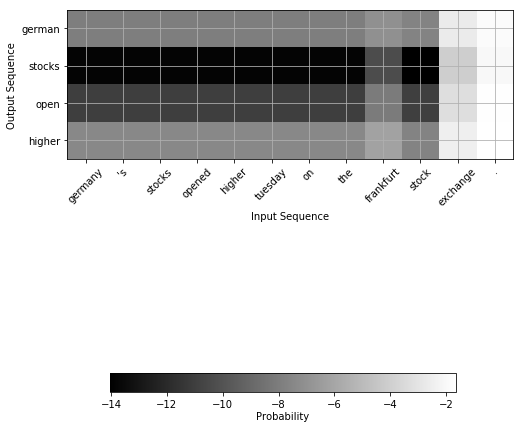

In [19]:
viz.attention_map(X_true[1875], np.expand_dims(X_test[1875], axis=0), y_idx2word)

### Input: 'share prices on the london stock exchange were higher at midday tuesday'
### Output: 'at london share prices higher at midday'
This is not a perfect output sequence prediction, if only because of the syntactic strangeness of the first bigram "at london." It does, however, convey an intelligible summary of the input sequence. Unlike the similar prediction discussed above, "exchange" is not given particular attention. For the output words "london" and "share," only the tokens given particular attention are used. For all other output words, the same tokens are given particular attention, but some attention is also distributed throughout the sentence. Similarly to the prediction discussed above, for this prediction the model gave attention primarily to words that are not generated in the output sequence, with the exception of "higher," which is given attention and appears in both input and output. Also similarly to the above prediction, the stop token '.' is given more attention than any other individual token in the input, particularly for the second half of the output sequence. Again, to me, this suggests that the model has learned the structure of sentences related to finance particularly well, and once it has seen the stop token and only seen finance-related words before it, it can predict the output with high confidence.

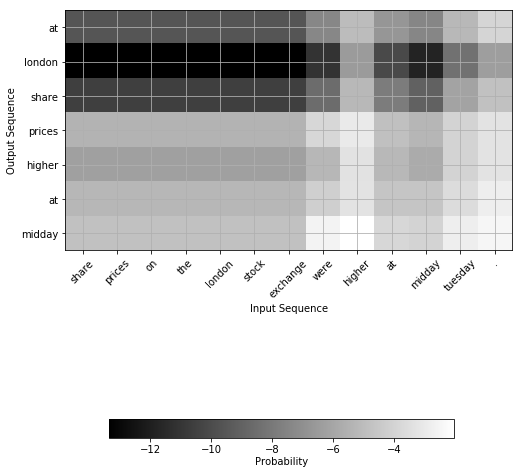

In [20]:
viz.attention_map(X_true[0], np.expand_dims(X_test[0], axis=0), y_idx2word)

### Input: 'tokyo stocks rose monday morning , lifted by hefty gains on wall street'
### Output: 'tokyo tokyo tokyo stocks higher dollar up against yen'

This is, of course, not one of the predictions with a near-perfect rouge score. It contains repeated words, is grammatically unsound, and, most importantly, incorrectly conveys that the dollar has risen against the yen, when in fact the yen has been lifted by the dollar. It _is_ a good prediction to the extent that it correctly paraphrases "wall street" as "dollar," associates "tokyo" with "yen," even though "yen" does not appear in the input sequence, and correctly states that tokyo stocks are higher. The model is predicting abstractively, paraphrasing "lifted by hefty gains on" as simply "higher." Once again, the most attention is given to the second half of the sequence, even though it is the words in the first half of the sequence that are correctly summarized. Once again, that "street" is given so much attention probably has more to do with its position as the final non-stopping token in the sentence than with the actual word itself. It is notable, however, that unlike the previous two finance-related predictions, the stop token '.' is not given particular attention, suggesting that although this prediction is somewhat worse that the other two, it does not seem to have been a result of overfitting.

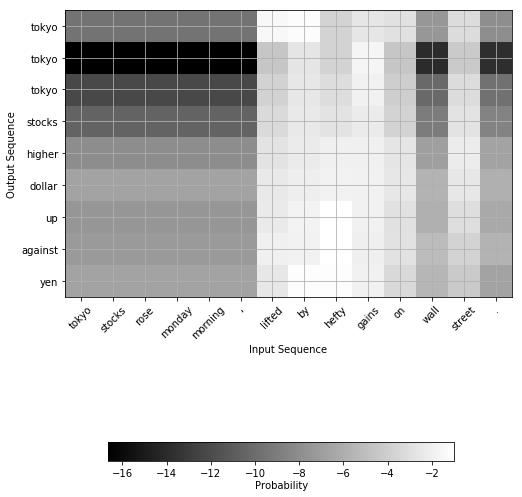

In [21]:
viz.attention_map(X_true[120], np.expand_dims(X_test[120], axis=0), y_idx2word)

### Input: former swiss president UNK UNK has died , it was announced monday
### Output: former president UNK dies president dies

This is a non-markets related prediction that is fairly good. It clearly conveys the most essential information from the input sequence. In addition to the fault of repeating "president dies" unnecessarily at the end, the prediction might be faulted for ignoring too much of the input sequence. For instance, it would be better to specify "swiss president" rather than just "president." Unlike the market-related predictions, attention seems to have been used very little in this prediction, being evenly distributed for each word in the output. The model does give less attention to the ',' token, and gives somewhat more attention to the first half of the input sentence than the second. It also relies more heavily on the input sequence to predict the end of the sentence than the beginning (lighter squares on the bottom).

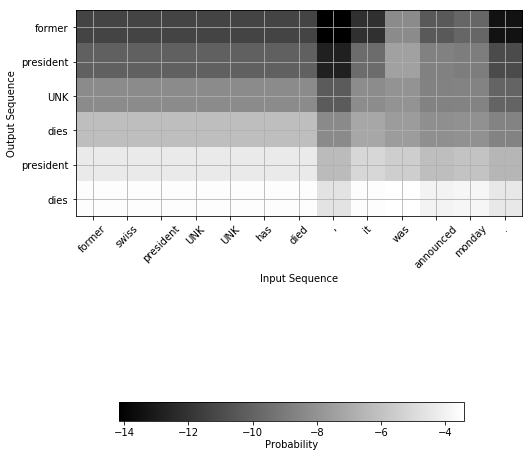

In [22]:
viz.attention_map(X_true[102], np.expand_dims(X_test[102], axis=0), y_idx2word)

### Input: treasury prices rose friday despite a strong february employment report
### Output: treasury treasury prices rise on treasury jobs data

This prediction sequence contains repeated words, mischaracterizes the "jobs data" as coming from the treasury, and is semantically incorrect in that while it is correct that prices rose "on" jobs data, this loses the meaning of the original sequence that prices rose "despite" jobs data. It is more or less syntactically fluent, however. The first half of the sentence seems to have been extractively generated, while the conversion of "employment report" to "jobs data" is abstractive. As with many of the predictions my model makes, the model makes this prediction by giving particular attention to the stopping character '.', and nearly equal attention to every other word. Also as with other predictions, the model barely references the input sequence in generating the second and third words.

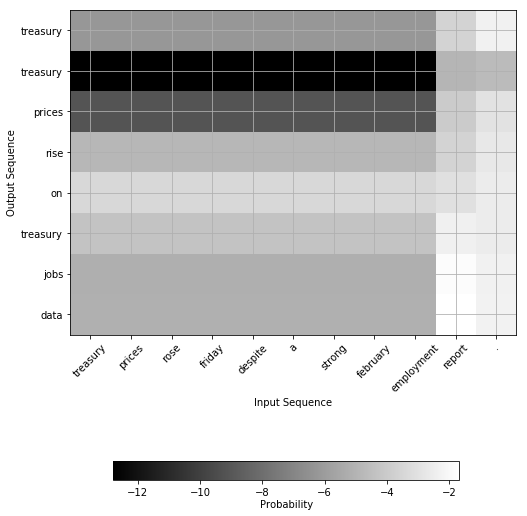

In [23]:
viz.attention_map(X_true[1401], np.expand_dims(X_test[1401], axis=0), y_idx2word)

### Some more examples of markets-related predictions with 0.999995 r2 f scores
### toggle to view

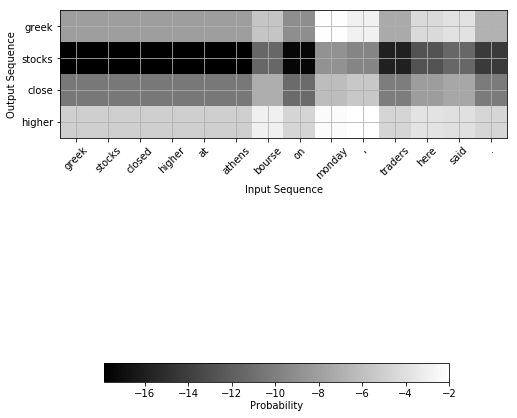

In [37]:
viz.attention_map(X_true[6725], np.expand_dims(X_test[6725], axis=0), y_idx2word)

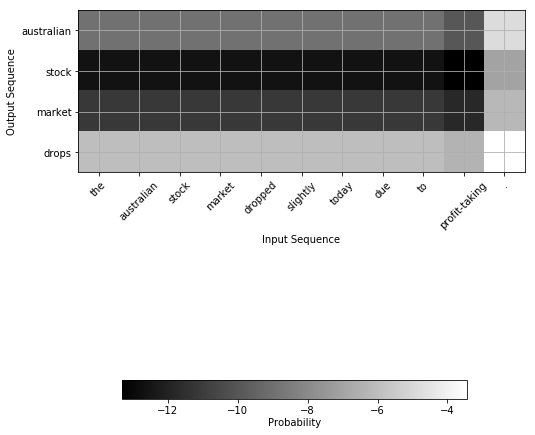

In [38]:
viz.attention_map(X_true[1863], np.expand_dims(X_test[1863], axis=0), y_idx2word)

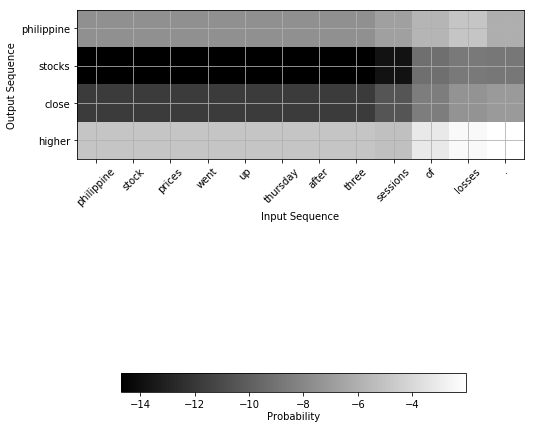

In [39]:
viz.attention_map(X_true[1777], np.expand_dims(X_test[1777], axis=0), y_idx2word)

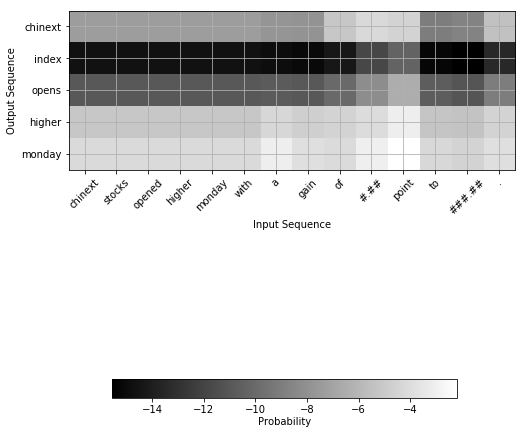

In [40]:
viz.attention_map(X_true[1629], np.expand_dims(X_test[1629], axis=0), y_idx2word)

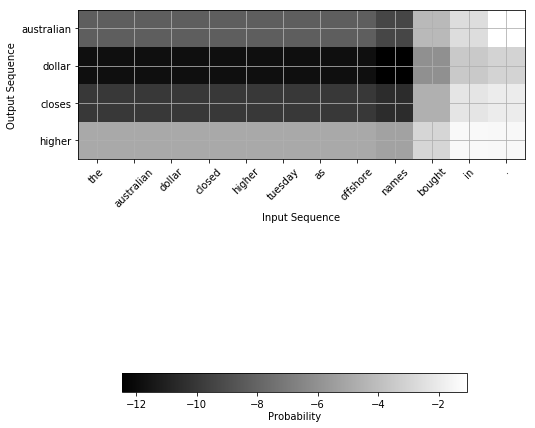

In [41]:
viz.attention_map(X_true[1628], np.expand_dims(X_test[1628], axis=0), y_idx2word)

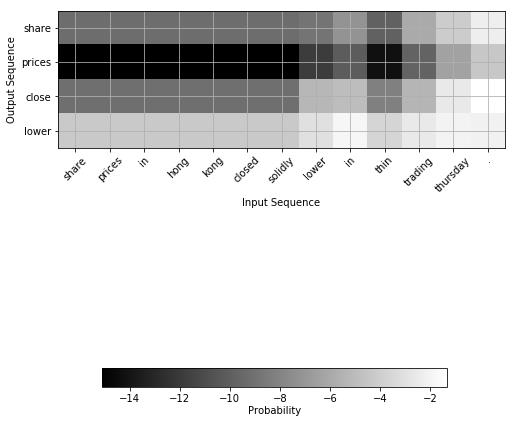

In [42]:
viz.attention_map(X_true[427], np.expand_dims(X_test[427], axis=0), y_idx2word)

## Visualization and analysis of bad predictions

### Some 0.0 Rouge-2 'f' scores

5,893 out of 7000 of the predictions had rouge scores of 0.0. A random selection of 20 are printed below. I selected one of them to supplement the four bad examples that I chose manually to illustrate particular shortcomings of the model.

In [171]:
r2_scores.sort(key= lambda r2: r2[1], reverse=False)
print("Randomly selected 20 rouge-2 'f' scores of 0.0 from 5,893 predictions with 0.0")
for i in range(5):
    idx = random.randint(0, 5892)
    print("{} : {}".format(r2_scores[idx], y_pred[r2_scores[idx][0]]))

Randomly selected 20 rouge-2 'f' scores of 0.0 from 5,893 predictions with 0.0
(5600, 0.0) : cowboys cowboys cowboys cowboys cowboys cowboys
(3706, 0.0) : UNK UNK UNK UNK for UNK UNK
(1987, 0.0) : final champions champions champions champions champions league league
(1315, 0.0) : UNK UNK UNK UNK UNK UNK UNK
(4022, 0.0) : german german stock exchange fall


### Input: the courses of three indexes on the frankfurt stock exchange fell friday
### Output: german german stock exchange fall

I included this prediction vizualization because it does not seem to be an especially bad prediction, but achieved a rouge-2 'f' score of 0. The gold title was "ecb message exchange rates." Perhaps the fact that this legible and accurate prediction with the minor error of repeating the first word achieved a 0.0 r2f score says something about the quality of the test data; perhaps it says something about the use of automatic rather than human evaluation of summarization tasks. The attention map for this prediction is very similar to the maps for other markets-related predictions that achieved high rouge scores.

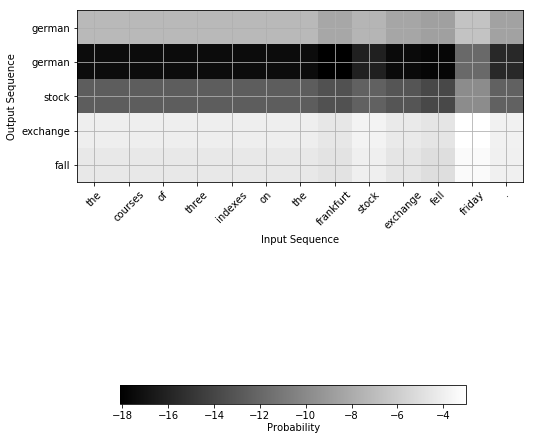

In [18]:
viz.attention_map(X_true[4022], np.expand_dims(X_test[4022], axis=0), y_idx2word)

### Input: the internet 's world wide web is a UNK place for parents and UNK
### Output: internet internet internet internet internet internet internet internet

This prediction is an example of my model's most vexing problem: producing output that is simply the first noun or word that can be a noun in the sentence and simply repeating it several times to produce input of appropriate length. The only redeeming quality of this prediction is that internet should, in fact, have been the first word of the output. The attention map for this predictions shares some characteristics with the attention maps of good predictions: the second word is generated with nearly no reference to the input sequence. Slightly more attention is given to the second half the sentence, but otherwise is fairly evenly distributed. across the sentence for every output prediction.

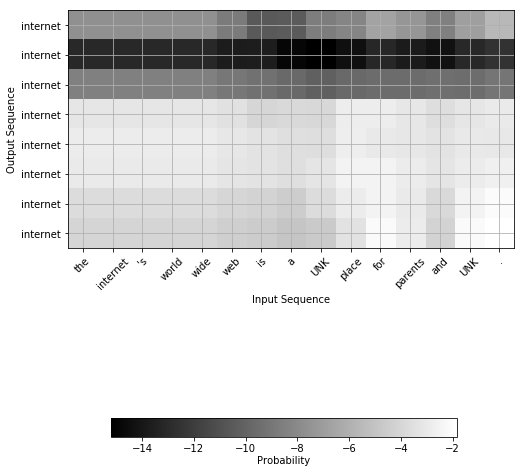

In [43]:
viz.attention_map(X_true[675], np.expand_dims(X_test[675], axis=0), y_idx2word)

### Input: the cal state northridge football team looked a lot different this time
### Output: northridge northridge northridge northridge northridge football northridge

This prediction, as with nearly all of my bad predictions, fails by repeating the same word, with the exception of the penultimate "football" token. There is little in the attention map to indicate why the second to last token is predicted differently, although the the attention paid to the end of the sentence is slightly higher for the "football" prediction.

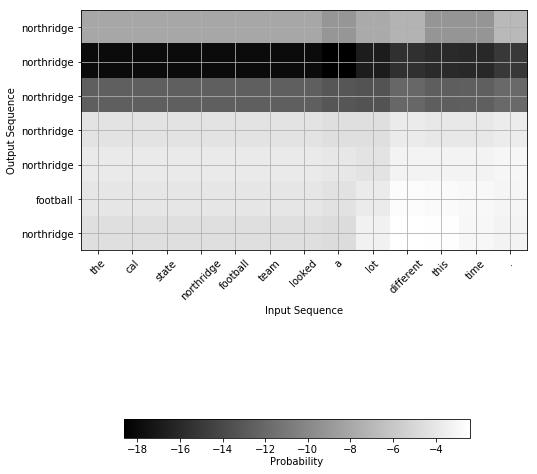

In [44]:
viz.attention_map(X_true[1199], np.expand_dims(X_test[1199], axis=0), y_idx2word)

### Input: mexican stocks closed higher wednesday, in line with u.s. equity gains.
### Output: up stocks stocks in mexico mexico chile; up in argentina chile

This is a markets-related prediction that is pretty terrible—both semantically and syntactically incoherent. THe prediction is largely generative: "stocks" and "mexico" are taken from the input sequence, but the model generates "argentina" and "chile" into the output, while losing "u.s.". As with other market-related predictions that performed higher, the most attention was given to the second half of the input sequence, and that attention was fairly evenly distributed across output predictions (a solid white column). And yet that is the part of the sequence that is most absent from the output. It is almost as if the model relies on the input sequence in determining what _not_ to include.

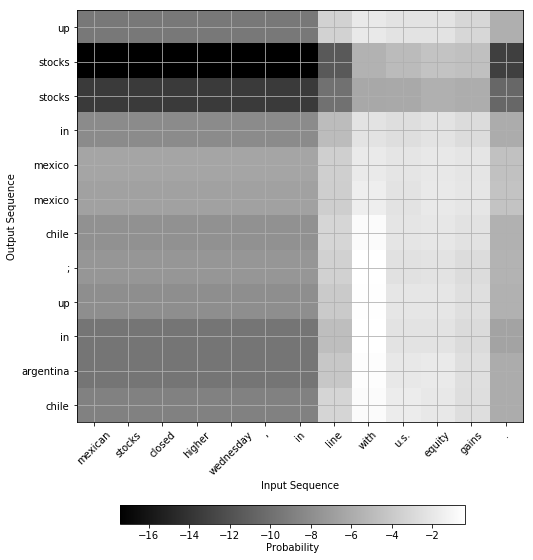

In [26]:
viz.attention_map(X_true[285], np.expand_dims(X_test[285], axis=0), y_idx2word)

### Input: john mccain and sarah palin will be back on the campaign trail together
### Output: mccain palin on on senate UNK

Like the above prediction, this sentence correctly compresses and includes certain key nouns ("mccain, "palin") while incorrectly abstractively generating the word "senate", and producing a syntactically and semantically incorrect prediction that has repeated words. In incorrectly generating the word "senate," the model pays the most attention to the input tokens "john mccain and sarah palin," which would make sense since john mccain was and is a senator, as the model may have seen training inputs in which mccain and senate appear together. Interestly, the model abstractively generated an UNK when no UNK was present in the input sentence. This is different from most other prediction where UNK was correctly in the output because it clearly was the important entity in the sentence. UNK was generated here with most attention given to "back" and "campaign."

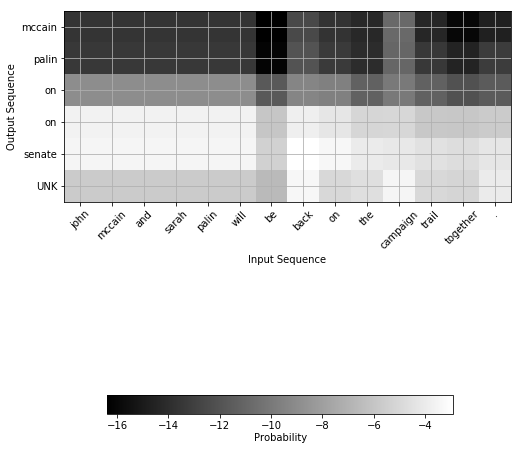

In [28]:
viz.attention_map(X_true[327], np.expand_dims(X_test[327], axis=0), y_idx2word)

# Proposals for model improvement

The most pervasive problem with my model was repeated words. This problem appears in two contexts:

1. The prediction is more or less syntactically and semantically correct, but locally repeats specific tokens more than once. For instance: "german german stock exchange fall."
2. The prediction consists entirely of a single repeated token or repeated n-gram. For example: "internet internet internet internet internet internet," or "space shuttle space shuttle space space space shuttle." In this case, the model usually takes the subject noun or noun phrase of the sentence as the token that gets repeated.

### Proposal for and implementation of solution to first context of repeated word problem

This problem has a very simple solution, which does not involve modifying the neural net architecture. The outputs would simply be post-processed and any repeated tokens would be compressed to a single instance.

I implement this solution below:

In [35]:
#given sentence, return sentence with duplicates removed
def remove_duplicates(sentence):
    sequence = sentence.split()
    clean_sequence = [sequence[0]]
    last_tok = clean_sequence[0]
    for tok in sequence[1:]:
        if tok == last_tok:
            continue
        else:
            clean_sequence.append(tok)
            last_tok = tok
    return " ".join(clean_sequence)

y_pred_clean = [remove_duplicates(sent) for sent in y_pred]

scores = Rouge().get_scores(hyps=y_pred, refs=y_true, avg=True)
scores_mod = Rouge().get_scores(hyps=y_pred_clean, refs=y_true, avg=True)

print("ROUGE SCORES WITH remove_duplicates IMPLEMENTED:\n")
print("\tROUGE 1 'r' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['r']), (100 * scores_mod['rouge-1']['r'])))
print("\tROUGE 1 'p' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['p']), (100 * scores_mod['rouge-1']['p'])))
print("\tROUGE 1 'f' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['f']), (100 * scores_mod['rouge-1']['f'])))
print()
print("\tROUGE 2 'r' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['r']), (100 * scores_mod['rouge-2']['r'])))
print("\tROUGE 2 'p' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['p']), (100 * scores_mod['rouge-2']['p'])))
print("\tROUGE 2 'f' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['f']), (100 * scores_mod['rouge-2']['f'])))


print("\nDIFFERENCE IN ROUGE 1:\n")
print("\tr: {:+}".format(100 * (scores_mod['rouge-1']['r'] - scores['rouge-1']['r'])))
print("\tp: {:+}".format(100 * (scores_mod['rouge-1']['p'] - scores['rouge-1']['p'])))
print("\tf: {:+}".format(100 * (scores_mod['rouge-1']['f'] - scores['rouge-1']['f'])))
print("\nDIFFERENCE IN ROUGE 2:\n")
print("\tr: {:+}".format(100 * (scores_mod['rouge-2']['r'] - scores['rouge-2']['r'])))
print("\tp: {:+}".format(100 * (scores_mod['rouge-2']['p'] - scores['rouge-2']['p'])))
print("\tf: {:+}".format(100 * (scores_mod['rouge-2']['f'] - scores['rouge-2']['f'])))

ROUGE SCORES WITH remove_duplicates IMPLEMENTED:

	ROUGE 1 'r' change: 17.39 --> 17.39
	ROUGE 1 'p' change: 35.23 --> 35.23
	ROUGE 1 'f' change: 21.56 --> 21.56

	ROUGE 2 'r' change: 6.17 --> 6.14
	ROUGE 2 'p' change: 6.39 --> 7.77
	ROUGE 2 'f' change: 6.06 --> 6.54

DIFFERENCE IN ROUGE 1:

	r: +0.0
	p: +0.0
	f: +0.0

DIFFERENCE IN ROUGE 2:

	r: -0.02719831755545951
	p: +1.381901154401155
	f: +0.475512850987278


### Results

ROUGE SCORES WITH remove_duplicates IMPLEMENTED:

	ROUGE 1 'r' change: 17.39 --> 17.39
	ROUGE 1 'p' change: 35.23 --> 35.23
	ROUGE 1 'f' change: 21.56 --> 21.56

	ROUGE 2 'r' change: 6.17 --> 6.14
	ROUGE 2 'p' change: 6.39 --> 7.77
	ROUGE 2 'f' change: 6.06 --> 6.54

DIFFERENCE IN ROUGE 1:

	r: +0.0
	p: +0.0
	f: +0.0

DIFFERENCE IN ROUGE 2:

	r: -0.02719831755545951
	p: +1.381901154401155
	f: +0.475512850987278

### Analysis of solution implementation results
Removing repeat tokens had no effect on the ROUGE 1 scores, led to a minimal decrease in ROUGE 2 recall score, and a marked increase in ROUGE 2 precision and f scores. The decrease in recall is explainable by the fact that this processing does not address the problem with sentences composed entirely of repeat unigrams and bigrams. Repeat unigrams reduced to a single unigram will result in lower recall scores, but the precision fraction will have a smaller denominator for all predictions that include true positives, and precision will therefore be higher. The decrease in recall is so insignificant that this is certainly a fix worth implementing.

# The broader repeated word problem

The solution to the first problem compresses "war war war war war" to "war", and single word predictions are hardly any better than a single word repeated eight times. The first context of the problem (discrete instances of repeated words in otherwise good predictions) is a subset of the  second, and so implementing a solution to the second problem would render the post-processing implemented above unnecessary. Finding a more global solution that would address both  contexts of the word repetition problem is more difficult. The better solutions, I will argue, would require  modifying the actual model architecture. Repeated words are almost never grammatical—the one exception being "that that," as in "I thought that that was a good prediction," though even this is ugly and undesirable syntax—and so we could safely set up the model in such a way that it should never allow repeated tokens in the output. I first describe and implement one sub-optimal but straightforward solution. I then describe two possible better solutions, without attempting to implement them.

## Proposed and implemented solution

### Modified greedy sequence generation

My original implementation of the attention model takes a straightforward greedy approach to generating the output sentence from the sequence of probability vectors returned by predict(attn_model, X_test). I made a minor modification to the greedy approach. I implemented the change in full below, but summarize it here in pseudocode:

```
for vector in sequence of vectors:
    index = argmax(vector)
    word = index_to_word[index]
    if word is not equal to 'ZERO':
        next_vector = the next vector in the sequence
        next_vector[index] = 0 #set probability of the next word being the same as the current word to 0
        #additional processing occurs (setting not in vocab words to UNK, etc.)
```

I saw a non-trivial improvement in ROUGE 1 recall and f score, and a fairly non-trivial improvement in all ROUGE 2 scores.

ROUGE SCORES WITH prevent_unigram_repetition IMPLEMENTED:

	ROUGE 1 'r' change: 17.39 --> 20.18
	ROUGE 1 'p' change: 35.23 --> 32.19
	ROUGE 1 'f' change: 21.56 --> 23.68

	ROUGE 2 'r' change: 6.17 --> 6.75
	ROUGE 2 'p' change: 6.39 --> 6.89
	ROUGE 2 'f' change: 6.06 --> 6.62

DIFFERENCE IN ROUGE 1:

	r: +2.784822027980141
	p: -3.0455272108843467
	f: +2.1146749301863417

DIFFERENCE IN ROUGE 2:

	r: +0.5770495377638247
	p: +0.5007616986188415
	f: +0.5554626775684288


For reasons I was unable to identify, the outputs still contained some duplicates, but the problem was somewhat reduced.

##### without modification to greedy generation: 
"war war war war war war war war"
##### with modification:
"war war war ii war UNK war"

Additionally, the modification did not solve the problem of bigram repetition:

##### without modification to greedy generation: 
"internet internet internet internet internet internet internet internet"
##### with modification: 
"internet web internet web internet web internet"

I added an additional check for bigram repetition, using the same approach, except instead of looking one step ahead I looked two steps behind:

```
where vector is sequence[i]
idx = argmax(vector)
if idx = argmax(sequence [i - 2]
vector[idx] = 0
idx = argmax(vector) #get new max
```

This additional modifcation gave me an even better increase in Rouge-1 r and f scores, about the same decrease in Rouge-1 p score, and a smaller increase in Rouge 2 scores over the original attention model:

ROUGE SCORES WITH remove_duplicates IMPLEMENTED:

	ROUGE 1 'r' change: 17.39 --> 22.25
	ROUGE 1 'p' change: 35.23 --> 29.59
	ROUGE 1 'f' change: 21.56 --> 24.64

	ROUGE 2 'r' change: 6.17 --> 6.58
	ROUGE 2 'p' change: 6.39 --> 6.42
	ROUGE 2 'f' change: 6.06 --> 6.36

DIFFERENCE IN ROUGE 1:

	r: +4.857180003497668
	p: -5.64335034013605
	f: +3.0728133574005447

DIFFERENCE IN ROUGE 2:

	r: +0.4146473111389083
	p: +0.031000824572252617
	f: +0.2942240343320038

The additional check for bigrams seems to have been successful, although the resulting predictions are not necessarily much more coherent:

##### without modification to greedy generation:
"internet internet internet internet internet internet internet internet"
##### with check for unigram repetition:
"internet web internet web internet web internet"
##### with check for bigram repetition:
"internet web the internet web UNK world"

### Summary of results for greedy search modification solution

While modifying the greedy search to prevent generation of unigrams and bigrams fixes the problem of word repetition, it does not result in significantly more semantically meaningful outputs. I therefore propose two further potential solutions to the problem of word repetition that would involve modifications to the actual neural net architecture, and might lead to more promising results.

##### analysis continued below code cell ....

In [41]:
#y_prob = attn_model.predict(X_test)

#process Y data for Rouge scoring by
#1. removing all 'ZERO' tokens
#2. replacing words not in train vocab with 'UNK'
    
y_pred_no_rep = []
    
for sequence in y_prob:
    sentence = []
    for i in range(len(sequence)):
        idx = np.argmax(sequence[i])
        word = y_idx2word[idx]
        if word != 'ZERO':
            #prevent unigram repetition
            if i+1 != len(sequence):
                sequence[i+1][idx] = 0.0
            
            #prevent bigram repetition
            if i - 2 >= 0:
                if np.argmax(sequence[i-2]) == idx:
                    sequence[i][idx] = 0.0
                    word = y_idx2word[np.argmax(sequence[i])]
            
            if word in y_idx2word:
                sentence.append(word)
            else:
                sentence.append(y_idx2word[-1]) #set to 'UNK'
    y_pred_no_rep.append(' '.join(sentence))

#uncomment if y_pred needs to be generated again
#y_pred = predict_on_model(attn_model, X_test) 

scores = Rouge().get_scores(hyps=y_pred, refs=y_true, avg=True)  
scores_mod = Rouge().get_scores(hyps=y_pred_no_rep, refs=y_true, avg=True)

print("ROUGE SCORES WITH remove_duplicates IMPLEMENTED:\n")
print("\tROUGE 1 'r' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['r']), (100 * scores_mod['rouge-1']['r'])))
print("\tROUGE 1 'p' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['p']), (100 * scores_mod['rouge-1']['p'])))
print("\tROUGE 1 'f' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-1']['f']), (100 * scores_mod['rouge-1']['f'])))
print()
print("\tROUGE 2 'r' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['r']), (100 * scores_mod['rouge-2']['r'])))
print("\tROUGE 2 'p' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['p']), (100 * scores_mod['rouge-2']['p'])))
print("\tROUGE 2 'f' change: {:.2f} --> {:.2f}".format((100 * scores['rouge-2']['f']), (100 * scores_mod['rouge-2']['f'])))


print("\nDIFFERENCE IN ROUGE 1:\n")
print("\tr: {:+}".format(100 * (scores_mod['rouge-1']['r'] - scores['rouge-1']['r'])))
print("\tp: {:+}".format(100 * (scores_mod['rouge-1']['p'] - scores['rouge-1']['p'])))
print("\tf: {:+}".format(100 * (scores_mod['rouge-1']['f'] - scores['rouge-1']['f'])))
print("\nDIFFERENCE IN ROUGE 2:\n")
print("\tr: {:+}".format(100 * (scores_mod['rouge-2']['r'] - scores['rouge-2']['r'])))
print("\tp: {:+}".format(100 * (scores_mod['rouge-2']['p'] - scores['rouge-2']['p'])))
print("\tf: {:+}".format(100 * (scores_mod['rouge-2']['f'] - scores['rouge-2']['f'])))

ROUGE SCORES WITH remove_duplicates IMPLEMENTED:

	ROUGE 1 'r' change: 17.39 --> 22.25
	ROUGE 1 'p' change: 35.23 --> 29.59
	ROUGE 1 'f' change: 21.56 --> 24.64

	ROUGE 2 'r' change: 6.17 --> 6.58
	ROUGE 2 'p' change: 6.39 --> 6.42
	ROUGE 2 'f' change: 6.06 --> 6.36

DIFFERENCE IN ROUGE 1:

	r: +4.857180003497668
	p: -5.64335034013605
	f: +3.0728133574005447

DIFFERENCE IN ROUGE 2:

	r: +0.4146473111389083
	p: +0.031000824572252617
	f: +0.2942240343320038



## Further proposed solutions

### Modified loss function

My current attention model uses sparse_categorical_crossentropy as its loss function.

<img src="crossent.png" width=200px>

One approach to fixing the repeated word problem would be to modify the loss function so that predictions with repeated words had very high penalties. This would be a complicated fix. The loss function has to be differentiable, so the function cannot simply be
```
if len(sequence) == len(set(sequence)): #no repeating words
    calculate loss using categorical crossentropy
else:
    give high scalar value as penalty
```
However, the python function that is called for loss could use this if-else structure, and if the output sequence has repeating words, return a different differentiable function that on average gives a higher penalty.

```
if len(sequence) == len(set(sequence)): #no repeating words
    calculate loss using categorical crossentropy
else:
    calculate loss using least square errors
```

### Multi-task learning

Although I have not pursued the topic in depth, I understand from this
[overview of multitask learning](http://ruder.io/multi-task/index.html#introduction)
that there has been work into building multiple neural nets learning different tasks and using different loss functions but sharing weights. If the repeating-word problem is not isolated to my architecture and in fact is an open problem with this task generally, then it may be worth attempting to jointly train neural nets with shared weights and shared inputs, one of whose tasks is to learn gold titles, and the other of whose tasks is to learn to generate sequences of unique words. The gold sequences for the second task would simply be any sequence of unique words. Although I am not particularly comfortable with tensorflow it seems doable to dynamically define gold sequences after the output is generated: simply look at the output and if it consists of unique words, set gold sequence = output sequence so that there is 0 loss. If does have repeated words, set gold sequence to something different from the output sequence — the more repeated words, the more different the generated gold sequence, the higher the loss will be.
  
<img src="mtl.png" width=600px>
  
Image sourced from blog post on MTL linked above